# Laboratorio 1: Fundamentos de Modelado Matemático e Implementación en Pyomo

### Integrantes

**Andrés Neira - a.neiras@uniandes.edu.co - 202123126**

**Kevin David Alvarez Romero - k.alvarezr@uniandes.edu.co - 202022834**

## Importaciones

In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.opt import SolverFactory
solver = SolverFactory('glpk')

## Carga de datos

In [2]:
escala = {'Maxima': 7, 'Alta' : 6, 'Media-Alta':5,
'Media':4, 'Media-Baja':3, 'Baja':2, 'Minima':1}
numero_avion = {'Avion 1':1, 'Avion 2':2, 'Avion 3':3}
numero_recurso = {'Alimentos Basicos':1, 'Medicinas':2, 'Equipos Medicos':3,
                 'Agua Potable':4, 'Mantas':5}

In [3]:
#Problema 1
df = pd.read_csv('./datosProblema1.csv', sep=';')
id_Tarea = df['ID Tarea'].astype(int).unique()
df['Escala de Prioridad'] = df['Prioridad'].map(escala)
escala_prioridad = df.set_index(['ID Tarea'])['Escala de Prioridad'].to_dict()
puntos_historia = df.set_index(['ID Tarea'])['Puntos'].to_dict()

#Problema 2
df2 = pd.read_csv('./datosProblema2.csv', sep=';')
id_Trabajador = df2['Trabajador'].dropna().astype(int).unique()
id_Trabajo = df2['Trabajo'].astype(int).unique()
ganancias_trabajo = df2.set_index(['Trabajo'])['Ganancia'].to_dict()
intensidad_trabajo = df2.set_index(['Trabajo'])['Horas'].to_dict()
intensidad_trabajador = df2.dropna(subset=['Trabajador','Horas Disponibles']).set_index('Trabajador')['Horas Disponibles'].to_dict()
#Problema 3
df3 = pd.read_csv('./datosProblema3.csv', sep=';')
df3['ID Avion'] = df3['Avion'].map(numero_avion)
id_aviones = df3['ID Avion'].dropna().astype(int).unique()
df3['ID Recurso'] = df3['Recurso'].map(numero_recurso)
id_recursos = df3['ID Recurso'].astype(int).unique()
valor_recurso = df3.set_index(['ID Recurso'])['Valor'].to_dict()
stock_recurso = df3.set_index(['ID Recurso'])['Stock '].to_dict()
volumen_recurso = df3.set_index(['ID Recurso'])['Volumen'].to_dict()
volumen_avion = df3.dropna(subset=['ID Avion', 'Capacidad Volumen']).set_index(['ID Avion'])['Capacidad Volumen'].to_dict()
volumen_avion = {int(k): v for k, v in volumen_avion.items()}
peso_avion = df3.dropna(subset=['ID Avion', 'Capacidad Peso']).set_index(['ID Avion'])['Capacidad Peso'].to_dict()
peso_avion = {int(k): v for k, v in peso_avion.items()}


## Problema 1A

### Definición del modelo

In [4]:
model1a = ConcreteModel()

#Conjuntos
model1a.I = Set(initialize= id_Tarea)

#Parametros
model1a.V_i = Param(model1a.I, initialize = escala_prioridad)
model1a.P_i = Param(model1a.I, initialize = puntos_historia)
model1a.C = Param(initialize = 52)

#Variables de decisión
model1a.X = Var(model1a.I, within=Binary)




### Función Objetivo

In [5]:
def obj_rule1a(model1a):
    return sum(model1a.V_i[i] * model1a.X[i] for i in model1a.I)

model1a.obj = Objective(rule = obj_rule1a, sense = maximize )

### Restricciones

In [6]:
def const_rule1a(model1a):
    return sum(model1a.X[i] * model1a.P_i[i] for i in model1a.I) <= model1a.C
model1a.capacidad_Equipo = Constraint(rule=const_rule1a)

### Resolución

In [7]:
result = solver.solve(model1a)

In [8]:
print("Estado del solver:", result.solver.termination_condition)
print("Valor óptimo:", model1a.obj())
for i in model1a.I:
    print(f"Tarea {i} -> {model1a.X[i].value}")

Estado del solver: optimal
Valor óptimo: 40.0
Tarea 1 -> 1.0
Tarea 2 -> 1.0
Tarea 3 -> 0.0
Tarea 4 -> 1.0
Tarea 5 -> 0.0
Tarea 6 -> 1.0
Tarea 7 -> 1.0
Tarea 8 -> 1.0
Tarea 9 -> 1.0
Tarea 10 -> 1.0
Tarea 11 -> 0.0


### Visualización de resultados

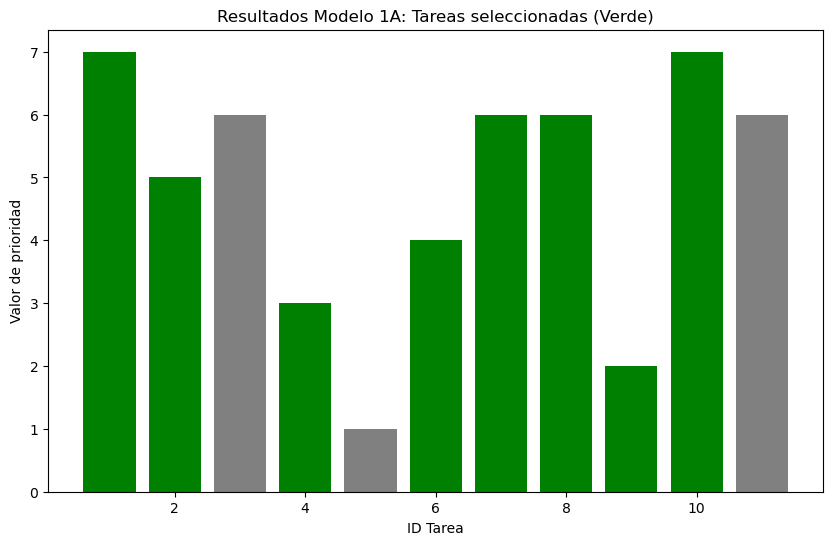

In [9]:
tareas = []
valores = []
puntos = []
seleccionadas = []

for i in model1a.I:
    if model1a.X[i].value == 1:
        tareas.append(i)
        valores.append(model1a.V_i[i])
        puntos.append(model1a.P_i[i])
        seleccionadas.append("Sí")
    else:
        tareas.append(i)
        valores.append(model1a.V_i[i])
        puntos.append(model1a.P_i[i])
        seleccionadas.append("No")

plt.figure(figsize=(10,6))
plt.bar(tareas, valores, color=["green" if s=="Sí" else "gray" for s in seleccionadas])
plt.xlabel("ID Tarea")
plt.ylabel("Valor de prioridad")
plt.title("Resultados Modelo 1A: Tareas seleccionadas (Verde)")
plt.show()

### Parte B

### Definición del modelo

In [10]:
model1b = ConcreteModel()

#Conjuntos
model1b.I = Set(initialize= id_Tarea)
model1b.J = Set(initialize= range(1,5)) #4 desarrolladores

#Parametros
model1b.V_i = Param(model1b.I, initialize = escala_prioridad)
model1b.P_i = Param(model1b.I, initialize = puntos_historia)
model1b.C_t = Param(initialize = 52)
model1b.C_d = Param(initialize = 15) 

#Variables de decisión
model1b.X = Var(model1b.I, model1b.J, within=Binary)

### Función objetivo

In [11]:
def obj_rule1b(model1b):
    return sum(model1b.V_i[i] * model1b.X[i, j] for i in model1b.I for j in model1b.J)

model1b.obj = Objective(rule = obj_rule1b, sense = maximize )

### Restricciones

In [12]:
def cap_global_1b(model1b):
    return sum(model1b.X[i,j] * model1b.P_i[i] for i in model1b.I for j in model1b.J) <= model1b.C_t

model1b.cap_global = Constraint(rule = cap_global_1b)

model1b.cap_grupo = ConstraintList()

for j in model1b.J:
    model1b.cap_grupo.add(sum(model1b.X[i,j] * model1b.P_i[i] for i in model1b.I) <= model1b.C_d)

model1b.asign_unica = ConstraintList()

for i in model1b.I:
    model1b.asign_unica.add(sum(model1b.X[i,j] for j in model1b.J)<=1)    

### Resolución

In [13]:
result = solver.solve(model1b)

print("Estado del solver:", result.solver.termination_condition)

print("Valor óptimo de la función objetivo:", model1b.obj())

print("\nAsignación de tareas:")
for i in model1b.I:
    for j in model1b.J:
        if model1b.X[i,j].value == 1:   # tarea i asignada a dev j
            print(f"Tarea {i} -> Desarrollador {j}")

print("\nUso de capacidad por desarrollador:")
for j in model1b.J:
    carga = sum(model1b.P_i[i] * model1b.X[i,j].value for i in model1b.I)
    print(f"Desarrollador {j}: {carga} puntos usados")

total_puntos = sum(model1b.P_i[i] * model1b.X[i,j].value 
                   for i in model1b.I for j in model1b.J)
print("\nTotal puntos usados en el equipo:", total_puntos)

Estado del solver: optimal
Valor óptimo de la función objetivo: 40.0

Asignación de tareas:
Tarea 1 -> Desarrollador 1
Tarea 2 -> Desarrollador 4
Tarea 4 -> Desarrollador 3
Tarea 6 -> Desarrollador 1
Tarea 7 -> Desarrollador 2
Tarea 8 -> Desarrollador 2
Tarea 9 -> Desarrollador 1
Tarea 10 -> Desarrollador 3

Uso de capacidad por desarrollador:
Desarrollador 1: 15.0 puntos usados
Desarrollador 2: 13.0 puntos usados
Desarrollador 3: 14.0 puntos usados
Desarrollador 4: 8.0 puntos usados

Total puntos usados en el equipo: 50.0


### Visualización de resultados

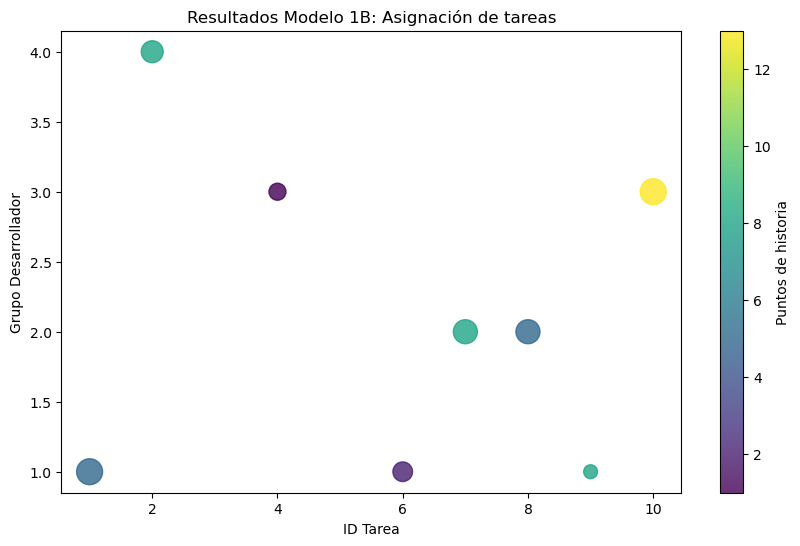

In [14]:
asignaciones = []
for i in model1b.I:
    for j in model1b.J:
        if model1b.X[i,j].value == 1:
            asignaciones.append((i, j, model1b.V_i[i], model1b.P_i[i]))

ids = [a[0] for a in asignaciones]
devs = [a[1] for a in asignaciones]
valores = [a[2] for a in asignaciones]
puntos = [a[3] for a in asignaciones]

plt.figure(figsize=(10,6))
plt.scatter(ids, devs, s=[v*50 for v in valores], c=puntos, cmap="viridis", alpha=0.8)
plt.colorbar(label="Puntos de historia")
plt.xlabel("ID Tarea")
plt.ylabel("Grupo Desarrollador")
plt.title("Resultados Modelo 1B: Asignación de tareas")
plt.show()

## Problema 2a

### Definición del modelo

In [15]:
model2a = ConcreteModel()

#Conjuntos
model2a.I = Set(initialize = id_Trabajador)
model2a.J = Set(initialize = id_Trabajo)

#Párametros
model2a.G_j = Param(model2a.J, initialize = ganancias_trabajo)
model2a.H_j = Param(model2a.J, initialize = intensidad_trabajo)
model2a.H_i = Param(model2a.I, initialize = intensidad_trabajador)

#Variables de decisión
model2a.X = Var(model2a.I, model2a.J, within = Binary)

### Función objetivo

In [16]:
model2a.obj = Objective(expr = sum(model2a.X[i,j] * model2a.G_j[j] for i in model2a.I for j in model2a.J), sense = maximize)

### Restricciones

In [17]:
model2a.restriccion_hora_trabajador = ConstraintList()
for i in model2a.I:
    model2a.restriccion_hora_trabajador.add(
        sum(model2a.X[i,j]*model2a.H_j[j] for j in model2a.J)<=model2a.H_i[i])

model2a.restriccion_asignacion_unica_trabajo = ConstraintList()

for j in model2a.J:
    model2a.restriccion_asignacion_unica_trabajo.add(
        sum(model2a.X[i,j] for i in model2a.I)<=1)

### Resolución

In [18]:
solver = SolverFactory('glpk') 
result = solver.solve(model2a)

print("Estado del solver:", result.solver.termination_condition)
print("Valor óptimo de la función objetivo:", model2a.obj())

print("\nAsignación de trabajos:")
for i in model2a.I:
    for j in model2a.J:
        if model2a.X[i,j].value == 1:
            print(f"Trabajador {int(i)} realiza el trabajo {int(j)}")

print("\nHoras usadas por trabajador:")
for i in model2a.I:
    horas_usadas = sum(model2a.H_j[j] * model2a.X[i,j].value for j in model2a.J)
    print(f"Trabajador {int(i)}: {horas_usadas} / {model2a.H_i[i]} horas")


total_horas = sum(model2a.H_j[j] * model2a.X[i,j].value for i in model2a.I for j in model2a.J)
print("\nTotal de horas usadas en el equipo:", total_horas)


Estado del solver: optimal
Valor óptimo de la función objetivo: 250.0

Asignación de trabajos:
Trabajador 1 realiza el trabajo 1
Trabajador 1 realiza el trabajo 5
Trabajador 2 realiza el trabajo 2
Trabajador 2 realiza el trabajo 3
Trabajador 3 realiza el trabajo 4

Horas usadas por trabajador:
Trabajador 1: 6.0 / 8.0 horas
Trabajador 2: 8.0 / 10.0 horas
Trabajador 3: 6.0 / 6.0 horas

Total de horas usadas en el equipo: 20.0


### Visualización de resultados

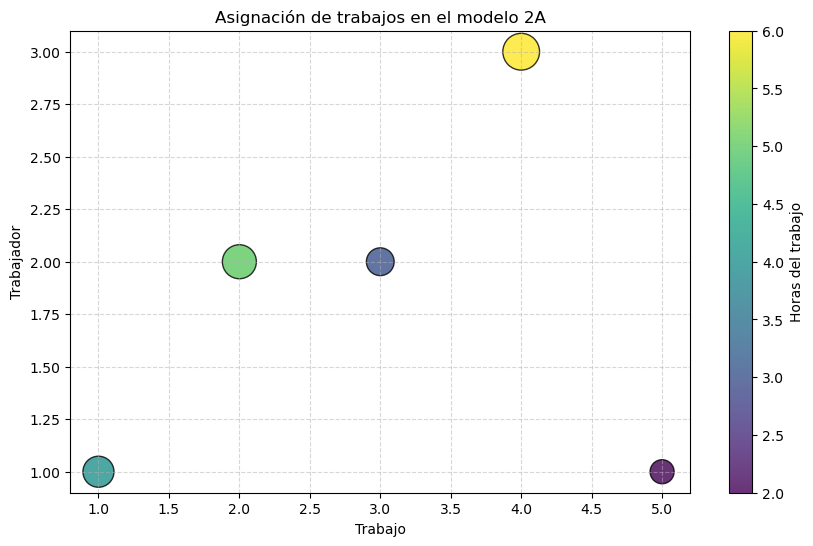

In [19]:
asignaciones = []
for i in model2a.I:
    for j in model2a.J:
        if model2a.X[i,j].value == 1:
            asignaciones.append((int(i), int(j), model2a.G_j[j], model2a.H_j[j]))

if asignaciones:
    trabajos = [a[1] for a in asignaciones]
    trabajadores = [a[0] for a in asignaciones]
    ganancias = [a[2] for a in asignaciones]
    horas = [a[3] for a in asignaciones]

    plt.figure(figsize=(10,6))
    scatter = plt.scatter(trabajos, trabajadores, s=[g*10 for g in ganancias],
                          c=horas, cmap="viridis", alpha=0.8, edgecolor="k")
    plt.colorbar(scatter, label="Horas del trabajo")
    plt.xlabel("Trabajo")
    plt.ylabel("Trabajador")
    plt.title("Asignación de trabajos en el modelo 2A")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("No hay asignaciones realizadas en el modelo.")


## Problema 2b

### Definición del modelo

In [20]:
model2b = ConcreteModel()

# Conjuntos
model2b.I = Set(initialize=id_Trabajador) 
model2b.J = Set(initialize=id_Trabajo)      

# Parámetros
model2b.G_j = Param(model2b.J, initialize=ganancias_trabajo)      
model2b.H_j = Param(model2b.J, initialize=intensidad_trabajo)    
model2b.H_i = Param(model2b.I, initialize=intensidad_trabajador)  

# Variables de decisión
model2b.X = Var(model2b.I, model2b.J, within=Binary)

### Función objetivo

In [21]:
model2b.obj = Objective(expr = sum(model2b.X[i,j] * model2b.G_j[j] for i in model2b.I for j in model2b.J), sense = maximize)

### Restricciones

In [22]:
model2b.restriccion_hora_trabajador = ConstraintList()
for i in model2b.I:
    model2b.restriccion_hora_trabajador.add(
        sum(model2b.X[i,j] * model2b.H_j[j] for j in model2b.J) <= model2b.H_i[i])

model2b.restriccion_asignacion_unica_trabajo = ConstraintList()
for j in model2b.J:
    model2b.restriccion_asignacion_unica_trabajo.add(
        sum(model2b.X[i,j] for i in model2b.I) <= 1)

model2b.restricción_trabajo1 = Constraint(
    expr = sum(model2b.X[i,1] for i in model2b.I if int(i) != 1)==0)

model2b.restriccion_trabajo3 = Constraint(expr = model2b.X[2,3]==0)


### Resolución

In [23]:
result = solver.solve(model2b)

print("Estado del solver:", result.solver.termination_condition)
print("Valor óptimo de la función objetivo:", model2b.obj())

print("\nAsignación de trabajos:")
for i in model2b.I:
    for j in model2b.J:
        if model2b.X[i,j].value == 1:
            print(f"Trabajador {int(i)} realiza el trabajo {int(j)}")

print("\nHoras usadas por trabajador:")
for i in model2b.I:
    horas_usadas = sum(model2b.H_j[j] * model2b.X[i,j].value for j in model2b.J)
    print(f"Trabajador {int(i)}: {horas_usadas} / {model2b.H_i[i]} horas")

total_horas = sum(model2b.H_j[j] * model2b.X[i,j].value for i in model2b.I for j in model2b.J)
print("\nTotal de horas usadas en el equipo:", total_horas)


Estado del solver: optimal
Valor óptimo de la función objetivo: 250.0

Asignación de trabajos:
Trabajador 1 realiza el trabajo 1
Trabajador 1 realiza el trabajo 3
Trabajador 2 realiza el trabajo 2
Trabajador 2 realiza el trabajo 5
Trabajador 3 realiza el trabajo 4

Horas usadas por trabajador:
Trabajador 1: 7.0 / 8.0 horas
Trabajador 2: 7.0 / 10.0 horas
Trabajador 3: 6.0 / 6.0 horas

Total de horas usadas en el equipo: 20.0


### Visualización de resultados

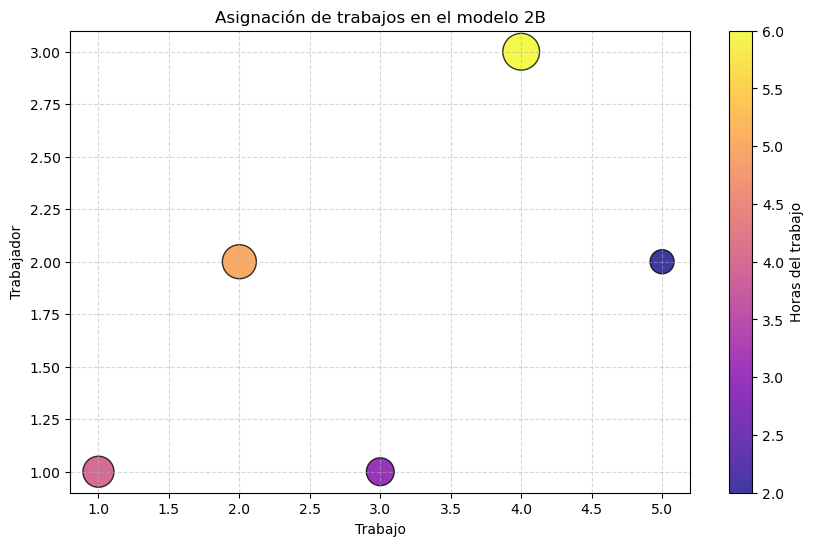

In [24]:
asignaciones = []
for i in model2b.I:
    for j in model2b.J:
        if model2b.X[i,j].value == 1:
            asignaciones.append((int(i), int(j), model2b.G_j[j], model2b.H_j[j]))

if asignaciones:
    trabajos = [a[1] for a in asignaciones]
    trabajadores = [a[0] for a in asignaciones]
    ganancias = [a[2] for a in asignaciones]
    horas = [a[3] for a in asignaciones]

    plt.figure(figsize=(10,6))
    scatter = plt.scatter(trabajos, trabajadores, 
                          s=[g*10 for g in ganancias], 
                          c=horas, cmap="plasma", alpha=0.8, edgecolor="k")
    plt.colorbar(scatter, label="Horas del trabajo")
    plt.xlabel("Trabajo")
    plt.ylabel("Trabajador")
    plt.title("Asignación de trabajos en el modelo 2B")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("No hay asignaciones realizadas en el modelo 2B.")


## Problema 3a

### Definición del modelo

In [25]:
model3a = ConcreteModel()

#Conjuntos
model3a.I = Set(initialize = id_aviones)
model3a.J = Set(initialize = id_recursos)

#Párametros
model3a.Val_j = Param(model3a.J, initialize = valor_recurso)
model3a.Stock_j = Param(model3a.J, initialize = stock_recurso)
model3a.Vol_j = Param(model3a.J, initialize = volumen_recurso)
model3a.CP_i = Param(model3a.I, initialize = peso_avion)
model3a.CV_i = Param(model3a.I, initialize = volumen_avion)

#Variables de decisión
model3a.X = Var(model3a.I, model3a.J, within = Binary)

### Función objetivo

In [26]:
model3a.obj = Objective(
    expr = sum(model3a.X[i,j]*model3a.Val_j[j] for i in model3a.I for j in model3a.J), sense = maximize)

### Restricciones

In [27]:
model3a.restriccion_peso = ConstraintList()
for i in model3a.I:
    model3a.restriccion_peso.add(
        sum(model3a.X[i,j]*model3a.Stock_j[j] for j in model3a.J)<=model3a.CP_i[i])

model3a.restriccion_volumen = ConstraintList()
for i in model3a.I:
    model3a.restriccion_volumen.add(
        sum(model3a.X[i,j]*model3a.Vol_j[j] for j in model3a.J)<=model3a.CV_i[i])

model3a.restriccion_repeticion_recursos = ConstraintList()
for j in model3a.J:
    model3a.restriccion_repeticion_recursos.add(
        sum(model3a.X[i,j] for i in model3a.I)<=1)



### Resolución

In [28]:
result = solver.solve(model3a)

print("Estado del solver:", result.solver.termination_condition)
print("Valor óptimo de la función objetivo:", model3a.obj())

print("\nAsignación de recursos a aviones:")
for i in model3a.I:
    for j in model3a.J:
        if model3a.X[i,j].value == 1:
            print(f"Avión {i} transporta el recurso {j}")

print("\nCapacidades usadas por avión:")
for i in model3a.I:
    peso_usado = sum(model3a.Stock_j[j] * model3a.X[i,j].value for j in model3a.J)
    volumen_usado = sum(model3a.Vol_j[j] * model3a.X[i,j].value for j in model3a.J)
    print(f"Avión {i}: {peso_usado}/{model3a.CP_i[i]} toneladas, "
          f"{volumen_usado}/{model3a.CV_i[i]} m³")

print("\nRecursos transportados:")
for j in model3a.J:
    asignado = sum(model3a.X[i,j].value for i in model3a.I)
    if asignado >= 1:
        print(f"Recurso {j} fue transportado")
    else:
        print(f"Recurso {j} NO fue transportado")


Estado del solver: optimal
Valor óptimo de la función objetivo: 370.0

Asignación de recursos a aviones:
Avión 1 transporta el recurso 3
Avión 1 transporta el recurso 5
Avión 2 transporta el recurso 1
Avión 2 transporta el recurso 2
Avión 2 transporta el recurso 4

Capacidades usadas por avión:
Avión 1: 30.0/30.0 toneladas, 16.0/25.0 m³
Avión 2: 38.0/40.0 toneladas, 22.0/30.0 m³
Avión 3: 0.0/50.0 toneladas, 0.0/35.0 m³

Recursos transportados:
Recurso 1 fue transportado
Recurso 2 fue transportado
Recurso 3 fue transportado
Recurso 4 fue transportado
Recurso 5 fue transportado


### Visualización de resultados

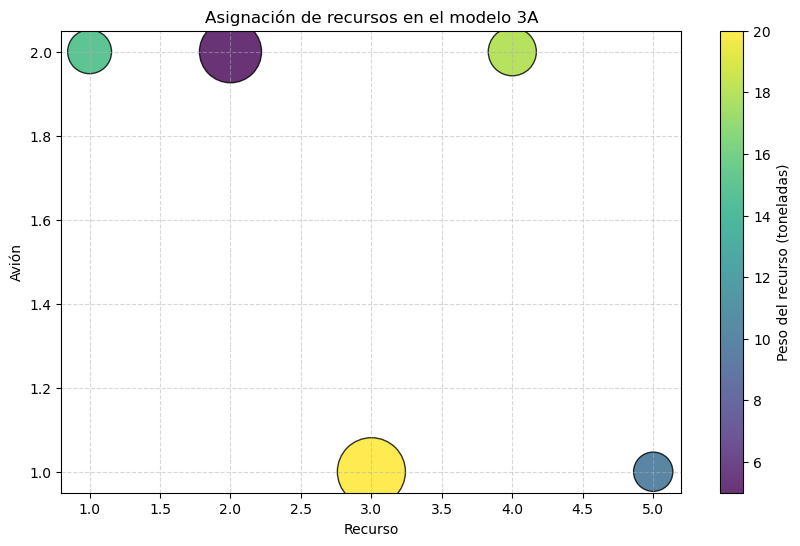

In [29]:
asignaciones = []
for i in model3a.I:
    for j in model3a.J:
        if model3a.X[i,j].value == 1:
            asignaciones.append((i, j, model3a.Val_j[j], model3a.Stock_j[j]))

if asignaciones:
    aviones = [a[0] for a in asignaciones]
    recursos = [a[1] for a in asignaciones]
    valores = [a[2] for a in asignaciones]
    pesos = [a[3] for a in asignaciones]

    plt.figure(figsize=(10,6))
    scatter = plt.scatter(recursos, aviones,
                          s=[v*20 for v in valores], 
                          c=pesos, cmap="viridis", alpha=0.8, edgecolor="k")
    plt.colorbar(scatter, label="Peso del recurso (toneladas)")
    plt.xlabel("Recurso")
    plt.ylabel("Avión")
    plt.title("Asignación de recursos en el modelo 3A")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("No hay asignaciones en el modelo 3A.")


## Problema 3b

### Definición del modelo

In [30]:
model3b = ConcreteModel()

# Conjuntos
model3b.I = Set(initialize=id_aviones)
model3b.J = Set(initialize=id_recursos)

# Parámetros
model3b.Val_j   = Param(model3b.J, initialize=valor_recurso)
model3b.Stock_j = Param(model3b.J, initialize=stock_recurso)
model3b.Vol_j   = Param(model3b.J, initialize=volumen_recurso)
model3b.CP_i    = Param(model3b.I, initialize=peso_avion)
model3b.CV_i    = Param(model3b.I, initialize=volumen_avion)

# Variables de decisión
model3b.X = Var(model3b.I, model3b.J, within=Binary)

### Función objetivo

In [31]:
model3b.obj = Objective(
    expr = sum(model3b.X[i,j]*model3b.Val_j[j] for i in model3b.I for j in model3b.J), sense = maximize)

### Restricciones

In [32]:
model3b.restriccion_peso = ConstraintList()
for i in model3b.I:
    model3b.restriccion_peso.add(
        sum(model3b.X[i,j] * model3b.Stock_j[j] for j in model3b.J) <= model3b.CP_i[i]
    )

model3b.restriccion_volumen = ConstraintList()
for i in model3b.I:
    model3b.restriccion_volumen.add(
        sum(model3b.X[i,j] * model3b.Vol_j[j] for j in model3b.J) <= model3b.CV_i[i]
    )

model3b.restriccion_repeticion_recursos = ConstraintList()
for j in model3b.J:
    model3b.restriccion_repeticion_recursos.add(
        sum(model3b.X[i,j] for i in model3b.I) <= 1
    )

model3b.restriccion_seguridad = Constraint(expr = model3b.X[1,2]==0)

def incompatibilidad_rule(model, i):
    return model.X[i,3] + model.X[i,4] <= 1

model3b.restriccion_incompatibilidad = Constraint(model3b.I, rule=incompatibilidad_rule)

### Resolución

In [33]:
result = solver.solve(model3b)

print("Estado del solver:", result.solver.termination_condition)
print("Valor óptimo de la función objetivo:", model3b.obj())

print("\nAsignación de recursos a aviones:")
for i in model3b.I:
    for j in model3b.J:
        if model3b.X[i,j].value == 1:
            print(f"Avión {i} transporta el recurso {j}")

print("\nCapacidades usadas por avión:")
for i in model3b.I:
    peso_usado = sum(model3b.Stock_j[j] * model3b.X[i,j].value for j in model3b.J)
    volumen_usado = sum(model3b.Vol_j[j] * model3b.X[i,j].value for j in model3b.J)
    print(f"Avión {i}: {peso_usado}/{model3b.CP_i[i]} toneladas, "
          f"{volumen_usado}/{model3b.CV_i[i]} m³")

print("\nRecursos transportados:")
for j in model3b.J:
    asignado = sum(model3b.X[i,j].value for i in model3b.I)
    if asignado >= 1:
        print(f"Recurso {j} fue transportado")
    else:
        print(f"Recurso {j} NO fue transportado")


Estado del solver: optimal
Valor óptimo de la función objetivo: 370.0

Asignación de recursos a aviones:
Avión 1 transporta el recurso 1
Avión 2 transporta el recurso 2
Avión 2 transporta el recurso 3
Avión 2 transporta el recurso 5
Avión 3 transporta el recurso 4

Capacidades usadas por avión:
Avión 1: 15.0/30.0 toneladas, 8.0/25.0 m³
Avión 2: 35.0/40.0 toneladas, 18.0/30.0 m³
Avión 3: 18.0/50.0 toneladas, 12.0/35.0 m³

Recursos transportados:
Recurso 1 fue transportado
Recurso 2 fue transportado
Recurso 3 fue transportado
Recurso 4 fue transportado
Recurso 5 fue transportado


### Visualización de resultados

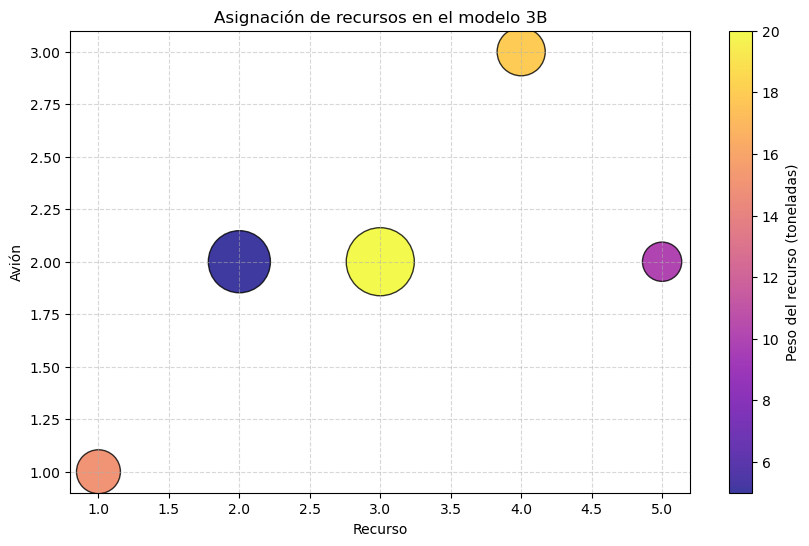

In [34]:
asignaciones = []
for i in model3b.I:
    for j in model3b.J:
        if model3b.X[i,j].value == 1:
            asignaciones.append((i, j, model3b.Val_j[j], model3b.Stock_j[j]))

if asignaciones:
    aviones = [a[0] for a in asignaciones]
    recursos = [a[1] for a in asignaciones]
    valores = [a[2] for a in asignaciones]
    pesos = [a[3] for a in asignaciones]

    plt.figure(figsize=(10,6))
    scatter = plt.scatter(recursos, aviones,
                          s=[v*20 for v in valores],
                          c=pesos, cmap="plasma", alpha=0.8, edgecolor="k")
    plt.colorbar(scatter, label="Peso del recurso (toneladas)")
    plt.xlabel("Recurso")
    plt.ylabel("Avión")
    plt.title("Asignación de recursos en el modelo 3B")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("No hay asignaciones en el modelo 3B.")
